# Model Visualization

In [178]:
from utils import *
from char_cnn_vis import *

import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import numpy as np, pandas as pd, os, json, time, sys, argparse, itertools
from datetime import datetime as dt


In [111]:
MODEL_FILENAME = "models/char_cnn.pt"

In [112]:
weights = torch.load(MODEL_FILENAME)


input_channel = 1
internal_channel = 32 ## range (10, 50, 10)
output_channel = 10
conv_kernel_size = 4
stride = 1
padding = 1
input_dim = 28
dropout = 0.2

## initialize model
print("Initializing model...")
model = CNN(input_channel, internal_channel, output_channel, conv_kernel_size, stride, padding, input_dim, dropout)
model.load_state_dict(weights)

Initializing model...
Conv block 1 initialized with output dimension: 13
Conv block 2 initialized with output dimension: 6
Initializing Linear layer with input dimension: 1152
Initializing Linear layer with input dimension: 128


<All keys matched successfully>

In [113]:
data = MNISTData()
percent_used = 0.1
batch_size = 16
data = data.get_dataloader(train = True, batch_size = batch_size, shuffle = True, perc_use = percent_used)

## Basic I/O

In [114]:
image, label = next(iter(data))

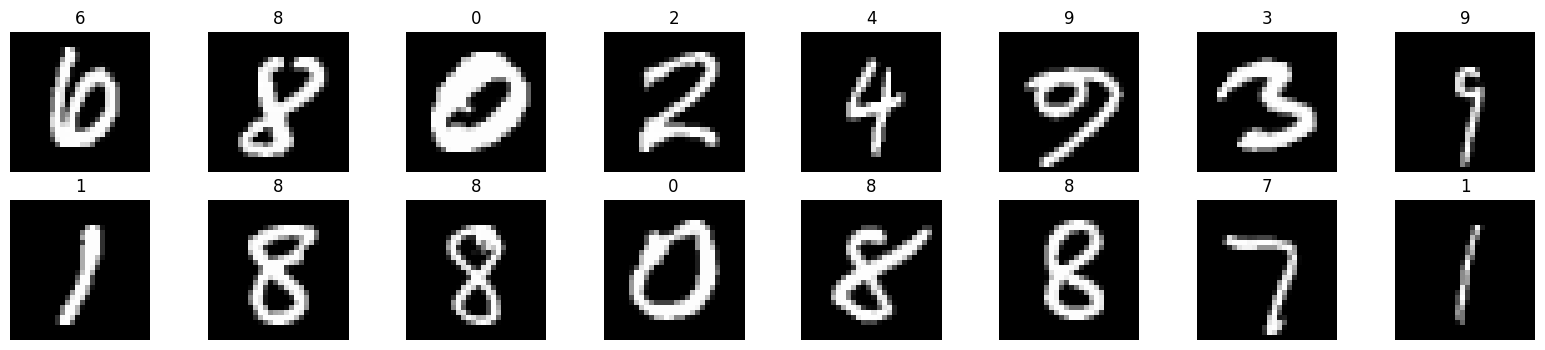

In [115]:
## Test data visualization
fig, ax = plt.subplots(int(batch_size / 8), 8, figsize = (20, 2*batch_size/8))
for i in range(batch_size):
    ax[int(i/8)][i % 8].imshow(image[i].reshape(28, 28), cmap = 'gray')
    ax[int(i/8)][i % 8].set_title(label[i].item())
    ax[int(i/8)][i % 8].axis('off')

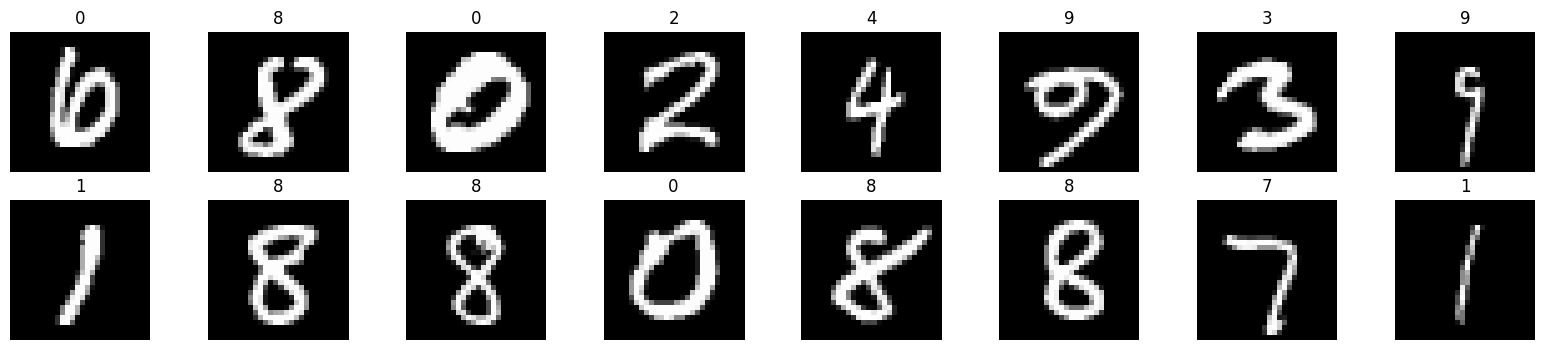

In [116]:
## Predictions
model.eval()
pred, loss = model(image)
pred = torch.argmax(pred, dim = 1)
fig, ax = plt.subplots(int(batch_size / 8), 8, figsize = (20, 2*batch_size/8))
for i in range(batch_size):
    ax[int(i/8)][i % 8].imshow(image[i].reshape(28, 28), cmap = 'gray')
    ax[int(i/8)][i % 8].set_title(pred[i].item())
    ax[int(i/8)][i % 8].axis('off')

## Feature Visualizaiton

In [117]:
## Print out all layers and their parameters
## Each convolutional block consists of a convolutional layer, a ReLU activation, and a max pooling layer
## But only the .conv2d layer has named parameters
for name, param in model.named_parameters():
    print(name, param.shape)
    
all_params = dict(model.named_parameters())

convolution_block_1.conv.weight torch.Size([32, 1, 4, 4])
convolution_block_1.conv.bias torch.Size([32])
convolution_block_2.conv.weight torch.Size([32, 32, 4, 4])
convolution_block_2.conv.bias torch.Size([32])
ff_1.weight torch.Size([128, 1152])
ff_1.bias torch.Size([128])
ff_2.weight torch.Size([10, 128])
ff_2.bias torch.Size([10])


### Kernels

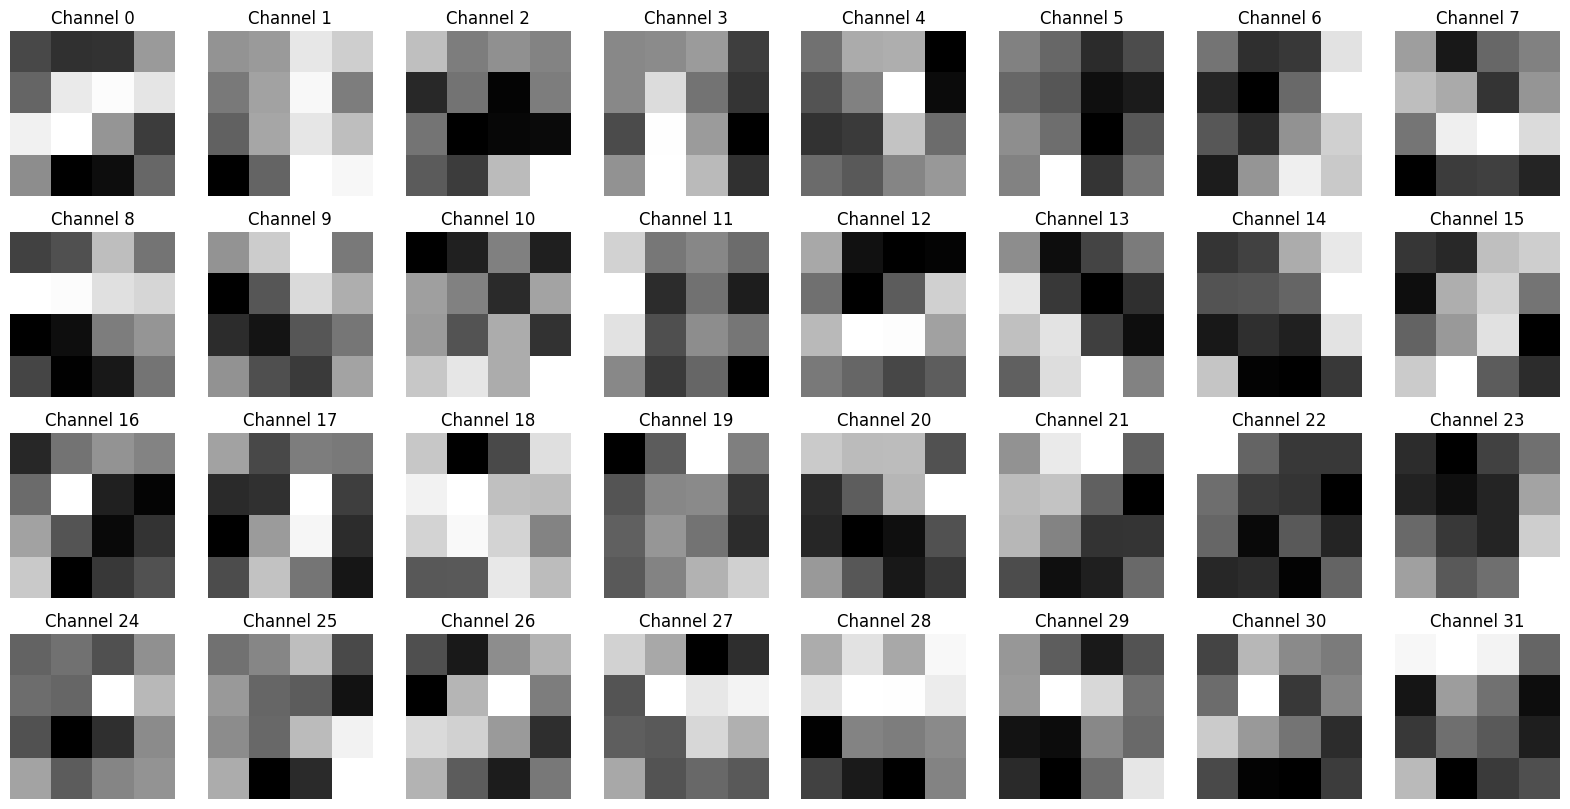

In [118]:
## Display all 32 output channels of kernels in the first convolutional layer
## Each kernel is 4x4
conv1_params = all_params['convolution_block_1.conv.weight'].detach().numpy()

fig, ax = plt.subplots(4, 8, figsize = (20, 10))
for i in range(32):
    ax[int(i/8)][i%8].imshow(conv1_params[i][0], cmap = 'gray')
    ax[int(i/8)][i%8].set_title(f"Channel {i}")
    ax[int(i/8)][i%8].axis('off')

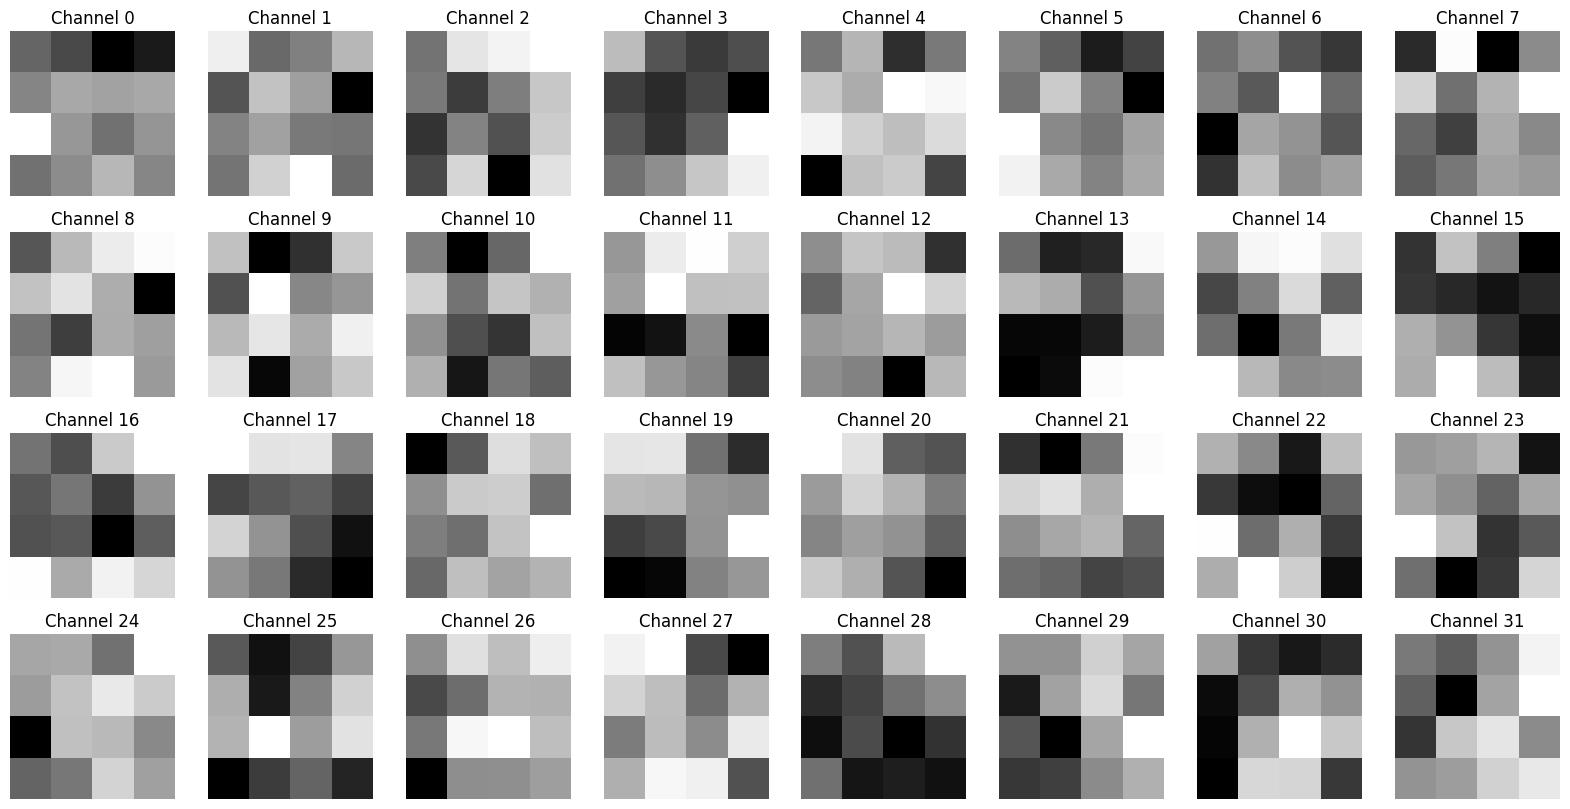

In [119]:
conv2_params = all_params['convolution_block_2.conv.weight'].detach().numpy()

fig, ax = plt.subplots(4, 8, figsize = (20, 10))
for i in range(32):
    ax[int(i/8)][i%8].imshow(conv2_params[i][0], cmap = 'gray')
    ax[int(i/8)][i%8].set_title(f"Channel {i}")
    ax[int(i/8)][i%8].axis('off')

### Activations

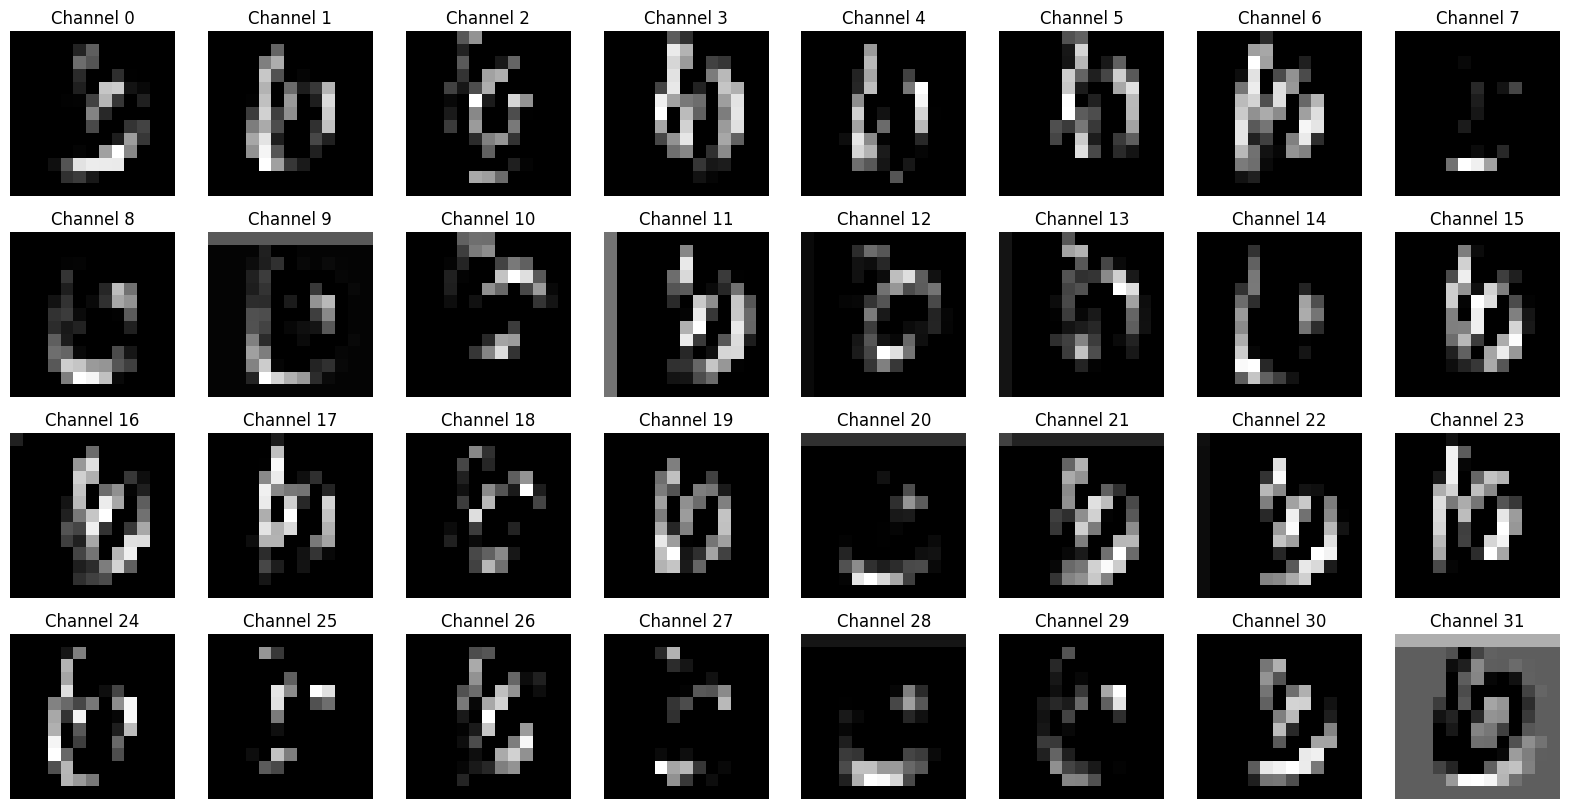

In [120]:
## Create a new model that only contains the first convolutional layer
conv1 = nn.Sequential(model.convolution_block_1.conv, model.convolution_block_1.activation, model.convolution_block_1.maxpool)
conv1.eval()

## Pass the image through the new model
conv1_output = conv1(image)

## Now we can visualize the output of each channel
fig, ax = plt.subplots(4, 8, figsize = (20, 10))
for i in range(32):
    ax[int(i/8)][i%8].imshow(conv1_output[0][i].detach().numpy(), cmap = 'gray')
    ax[int(i/8)][i%8].set_title(f"Channel {i}")
    ax[int(i/8)][i%8].axis('off')

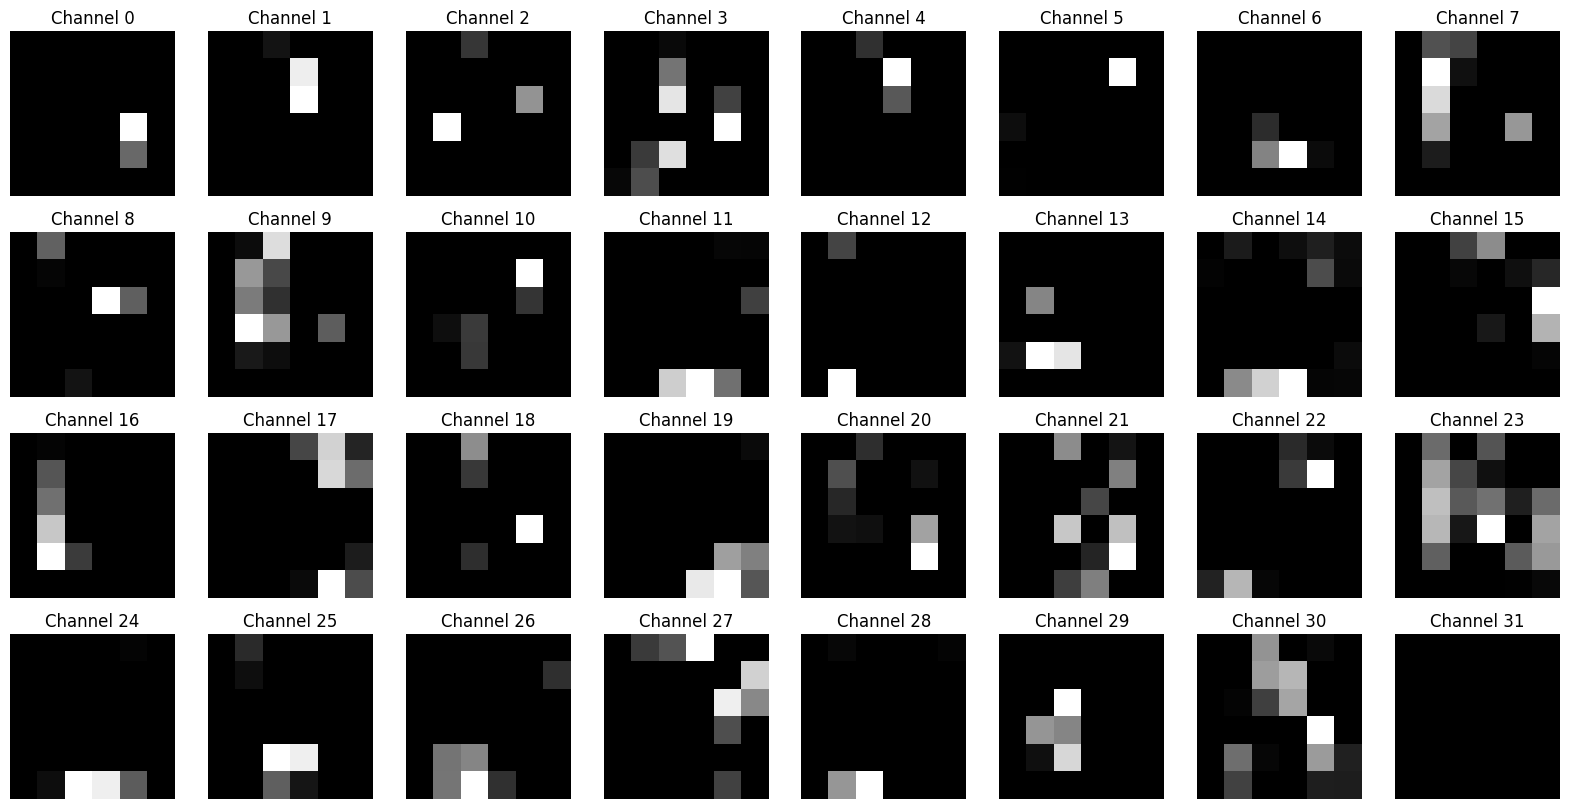

In [121]:
## Create a new model that only contains the second convolutional layer
conv2 = nn.Sequential(model.convolution_block_2.conv, model.convolution_block_2.activation, model.convolution_block_2.maxpool)
conv2.eval()

## Pass the image through the new model
conv2_output = conv2(conv1_output)

## Now we can visualize the output of each channel
fig, ax = plt.subplots(4, 8, figsize = (20, 10))
for i in range(32):
    ax[int(i/8)][i%8].imshow(conv2_output[0][i].detach().numpy(), cmap = 'gray')
    ax[int(i/8)][i%8].set_title(f"Channel {i}")
    ax[int(i/8)][i%8].axis('off')

## Attribution

In [100]:
# https://captum.ai/tutorials/IMDB_TorchText_Interpret
# https://www.youtube.com/watch?v=Am2EF9CLu-g&t=1s&ab_channel=PyTorch
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

### Integrated Gradients

In [225]:
class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        output, loss = self.model(x)
        return output

wrapped_model = Wrapper(model)

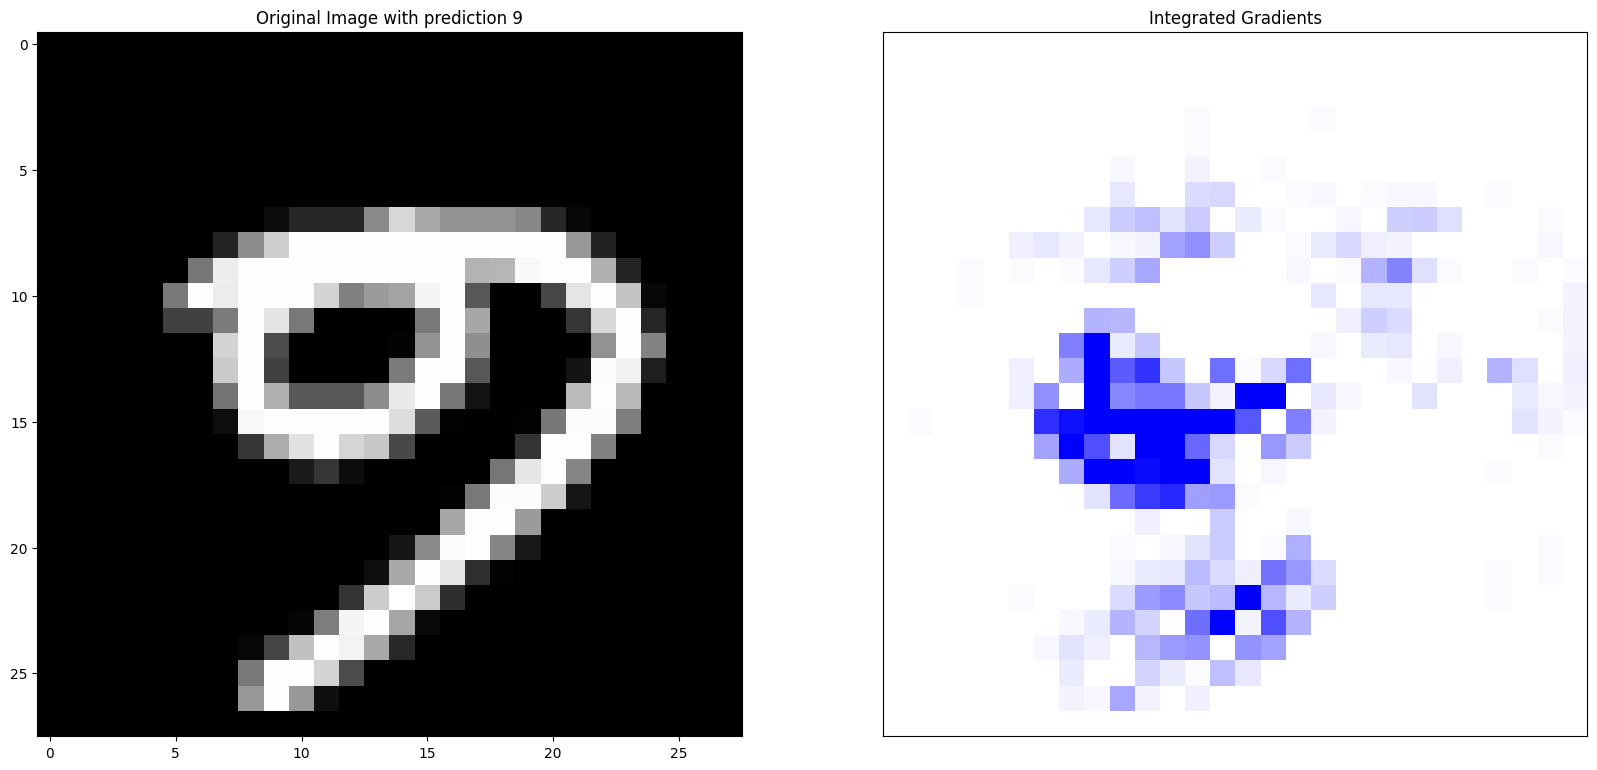

(<Figure size 2000x1000 with 2 Axes>,
 <AxesSubplot: title={'center': 'Integrated Gradients'}>)

In [228]:
## Generate attributions
sample = image[5].reshape(1, 1, 28, 28)
TARGET_CLASS = wrapped_model(sample).argmax()

ig = IntegratedGradients(wrapped_model)
ig_attr = ig.attribute(sample, target = TARGET_CLASS, n_steps = 100)

## Visualize the attributions
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].imshow(sample.reshape(28, 28), cmap = 'gray')
ax[0].set_title('Original Image with prediction {}'.format(TARGET_CLASS))

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

viz.visualize_image_attr(np.transpose(ig_attr.reshape(1,28,28).detach().numpy(), (1, 2, 0)),
                             np.transpose(sample.reshape(1,28,28).detach().numpy(),(1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             sign='positive',
                             title='Integrated Gradients',
                            plt_fig_axis = (fig, ax[1])
                        )   